In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [44]:
%reload_ext rpy2.ipython

# Raw SFW values

In [45]:
data=pd.read_csv('sfw_tr.csv')

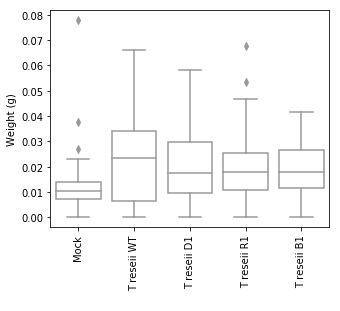

In [46]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.boxplot(x='Treatment',y='Weight',data=data,color='white',ax=ax)
#sns.swarmplot(x='Treatment',y='Weight',data=data,color='grey',ax=ax)
plt.xticks(rotation='vertical')
ax.set_ylabel('Weight (g)')
ax.set_xlabel(' ')
plt.savefig('sfw_mutants.pdf',bbox_inches='tight')

# Analysing Plant Performance Indexes

In [47]:
data['Plate']=data['Replicate']+data['Treatment']+data['Plate'].astype(str)

In [48]:
df=[]
order={'Mock':1,'T reseii WT':2,'T reseii D1':3,'T reseii R1':4,'T reseii B1':5}
for plate in set(data['Plate']):
    dfPlate=data[data['Plate']==plate]
    index=sum(list(dfPlate['Weight']))/len(dfPlate)
    df.append({'value':index, 'order':order[list(dfPlate['Treatment'])[0]], 'plate':plate,'treatment':list(dfPlate['Treatment'])[0], 'replicate':list(dfPlate['Replicate'])[0]})
df=pd.DataFrame(df).sort_values(by='order')

Text(0.5, 0, ' ')

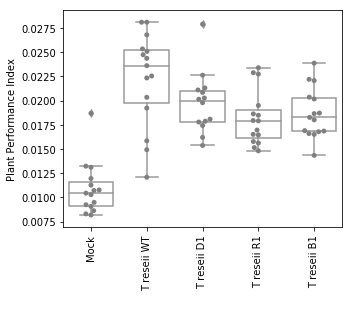

In [49]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.boxplot(x='treatment',y='value',data=df,color='white')
sns.swarmplot(x='treatment',y='value',data=df,color='grey')
plt.xticks(rotation='vertical')
ax.set_ylabel('Plant Performance Index')
ax.set_xlabel(' ')
#plt.savefig('ppi_mutants.pdf',bbox_inches='tight')

In [50]:
%%R -i df -o T
df$treatment <- as.factor(df$treatment)
LM<-lm(value~treatment,data=df)
#qqnorm(residuals(LM))
#qqline(residuals(LM))
summary(aov(LM))
T<-TukeyHSD(aov(LM))$treatment
T

/home/mesny/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


                                 diff           lwr         upr        p adj
T reseii B1-Mock         0.0077961905  0.0043898156 0.011202565 1.508968e-07
T reseii D1-Mock         0.0088744558  0.0054077864 0.012341125 6.426703e-09
T reseii R1-Mock         0.0072923810  0.0038860061 0.010698756 8.141351e-07
T reseii WT-Mock         0.0113390476  0.0079326728 0.014745422 0.000000e+00
T reseii D1-T reseii B1  0.0010782653 -0.0023884041 0.004544935 9.064336e-01
T reseii R1-T reseii B1 -0.0005038095 -0.0039101844 0.002902565 9.936851e-01
T reseii WT-T reseii B1  0.0035428571  0.0001364823 0.006949232 3.749584e-02
T reseii R1-T reseii D1 -0.0015820748 -0.0050487442 0.001884595 7.052155e-01
T reseii WT-T reseii D1  0.0024645918 -0.0010020775 0.005931261 2.810213e-01
T reseii WT-T reseii R1  0.0040466667  0.0006402918 0.007453042 1.188283e-02


# Analyse colonization indexes

In [51]:
def parseTable(folder,wellToDrop=[]):
    #Open file
    df=pd.read_csv(folder+'/'+[a for a in os.listdir(folder) if ' Quantification Cq Results_0.csv' in a][0], sep=';',decimal=',')
    df=df[~df['Well'].isin(wellToDrop)]
    df=df.drop(columns=['Unnamed: 0','Content','Biological Set Name','Cq Std. Dev','Starting Quantity (SQ)','Log Starting Quantity','SQ Mean','SQ Std. Dev','Set Point','Well Note'])
    for i in df.index:
        if df.loc[i,'Well'][0] in ['A','B','E','F']:
            df.loc[i,'Target']='ITS1'
        else:
            df.loc[i,'Target']='UBQ10'
    
        if df.loc[i,'Well'][0] in ['A','B','C','D']:
            df.loc[i,'Sample']=int(df.loc[i,'Well'][1:])
        else:
            df.loc[i,'Sample']=int(df.loc[i,'Well'][1:])+12
    df=df.merge(pd.read_csv(folder+'/plate.csv'), on='Sample')
    return df.sort_values(by=['Treatment','Replicate'])

def calculateIndex(df):
    values={}
    ratios={}
    for i in set(df['Sample']):
        #print(df[(df['Sample']==i)])
        ubq10=df[(df['Sample']==i) & (df['Target']=='UBQ10')]['Cq'].mean()
        its1=df[(df['Sample']==i) & (df['Target']=='ITS1')]['Cq'].mean()
        ##Kasia's calculation
        #values[i]=((2**(-its1))/(2**(-ubq10)))
        ratios[i]=its1/ubq10
        values[i]=2**(-(ratios[i]-ratios[1.0]))
    df['Value']=df['Sample'].map(values)
    return df[['Sample_ref','Treatment','Replicate','Value']].drop_duplicates()

In [52]:
n=0
results={}
wellsToDrop={'qPCRcolonization_05_R3R4':['E02','E09','F09','G09','H09']}
Dir='./'
for f in sorted(os.listdir(Dir)):
    if 'qPCRcolonization_' in f:
        if f in wellsToDrop:
            wtd=wellsToDrop[f]
        else:
            wtd=[]
        results[f]=calculateIndex(parseTable(Dir+f,wtd))
        if n>0:
            results[f]=results[f][results[f]['Sample_ref']!='TW1']
        n+=1
qPCR=pd.concat(results.values())

In [53]:
qPCR=qPCR[qPCR['Treatment']!='Mock']

In [54]:
order={'Mock':1,'T. reseii WT':2,'T. reseii D1':3,'T. reseii R1':4,'T. reseii B1':5}
qPCR['order']=qPCR['Treatment'].map(order)

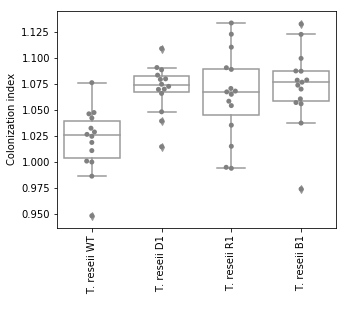

In [55]:
fig,ax=plt.subplots(1,1,figsize=(5,4))
sns.boxplot(x='Treatment',y='Colonization index',data=qPCR.rename(columns={'Value':'Colonization index'}).sort_values(by='order'),color='white',ax=ax)
sns.swarmplot(x='Treatment',y='Colonization index',color='grey',data=qPCR.rename(columns={'Value':'Colonization index'}).sort_values(by='order'),ax=ax)
plt.xticks(rotation='vertical')
ax.set_xlabel(' ')
plt.savefig('expMutants.pdf',bbox_inches='tight')

In [56]:
%%R -i qPCR
qPCR$Treatment<-as.factor(qPCR$Treatment)
kruskal.test(Value~Treatment,data=qPCR)
library(DescTools)
DunnTest(Value~Treatment,data=qPCR)

/home/mesny/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



 Dunn's test of multiple comparisons using rank sums : holm  

                          mean.rank.diff   pval    
T. reseii D1-T. reseii B1     -0.6142857 1.0000    
T. reseii R1-T. reseii B1     -4.7333333 1.0000    
T. reseii WT-T. reseii B1    -22.9000000 0.0016 ** 
T. reseii R1-T. reseii D1     -4.1190476 1.0000    
T. reseii WT-T. reseii D1    -22.2857143 0.0024 ** 
T. reseii WT-T. reseii R1    -18.1666667 0.0152 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

